In [ ]:
import pandas as pd
import numpy as np
train = pd.read_csv('/content/drive/MyDrive/580project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/580project/test.csv')

train = train[~train['Summary'].isnull()]
test = test[~test['Summary'].isnull()]
train = train.sample(30000)
test = test.sample(1000)

In [ ]:
text_count = []
summary_count = []
for sent in train['Text']:
    text_count.append(len(sent.split()))
for sent in train['Summary']:
    summary_count.append(len(sent.split()))

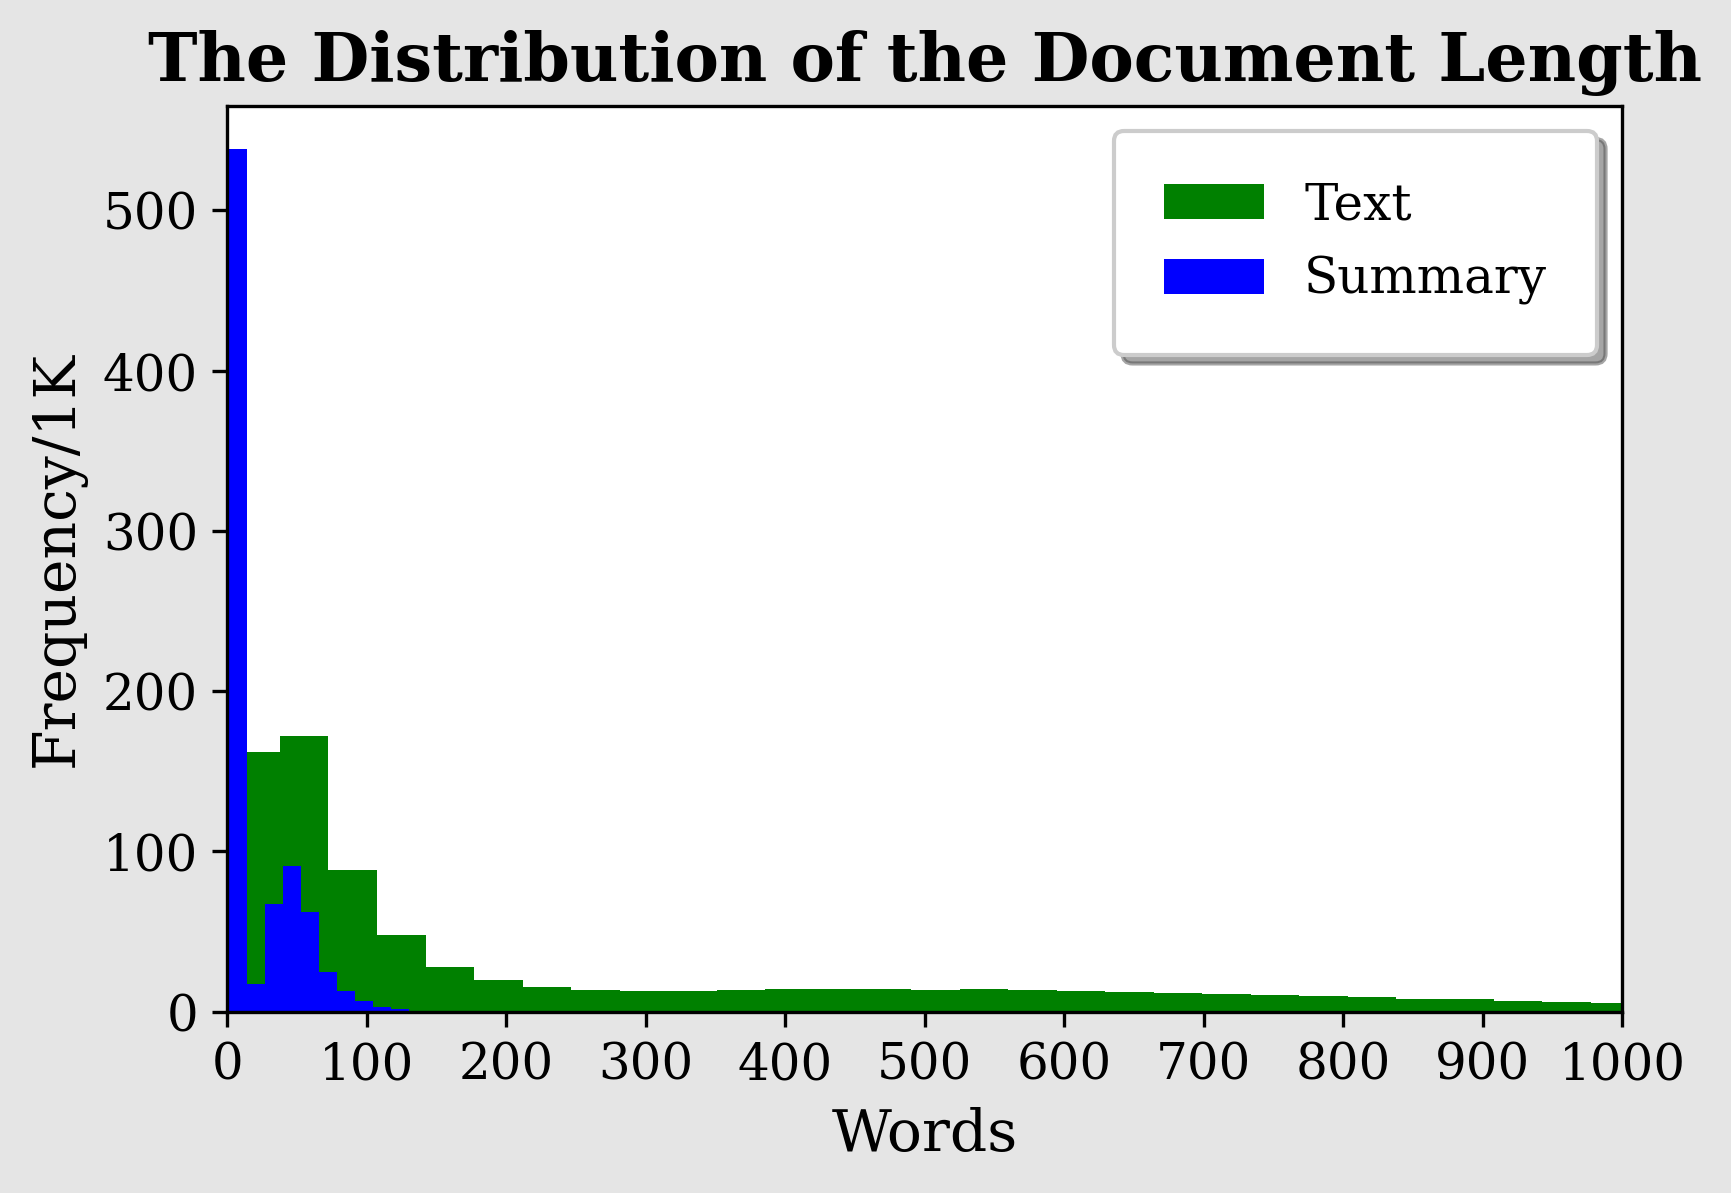

In [ ]:
from matplotlib import rcParams

# Plot parameters
rcParams['figure.dpi'] = 300
rcParams['font.family'] = "Serif"
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.facecolor'] = '#E5E5E5'

import matplotlib.pyplot as plt
plt.hist(text_count, bins=100, color='g', label='Text')
plt.hist(summary_count, bins=100, color='b', label='Summary')
plt.yticks(np.arange(0,600000,100000), np.arange(0,600,100))
plt.xticks(np.arange(0,1001,100), np.arange(0,1001,100))
plt.xlim(0,1000)
plt.ylabel('Frequency/1K')
plt.xlabel('Words')
plt.legend()
plt.title('The Distribution of the Document Length',
          fontsize = 16, fontweight = 'bold')
plt.legend(fancybox=True,framealpha=1, shadow=True, borderpad=1,
           fontsize=12)
plt.savefig('/content/drive/MyDrive/Distribution.png')
plt.show()

In [ ]:
max_text_len= 150
max_summary_len=50

In [ ]:
import numpy as np
cleaned_text =np.array(train['Text'])
cleaned_summary = np.array(train['Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre.shape

(17334, 2)

In [ ]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
x_tr = post_pre['text']
y_tr = post_pre['summary']

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(x_tr))
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
ymax = tot_cnt-cnt
ymax

8133

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
x_tokenizer = Tokenizer(num_words=8140) # 196053
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 

#padding zero upto maximum length
x_tr  =  pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

8141

In [ ]:
y_tokenizer = Tokenizer(num_words=1330) # 49147 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq   =   y_tokenizer.texts_to_sequences(y_tr) 

#padding zero upto maximum length
y_tr   =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

1331

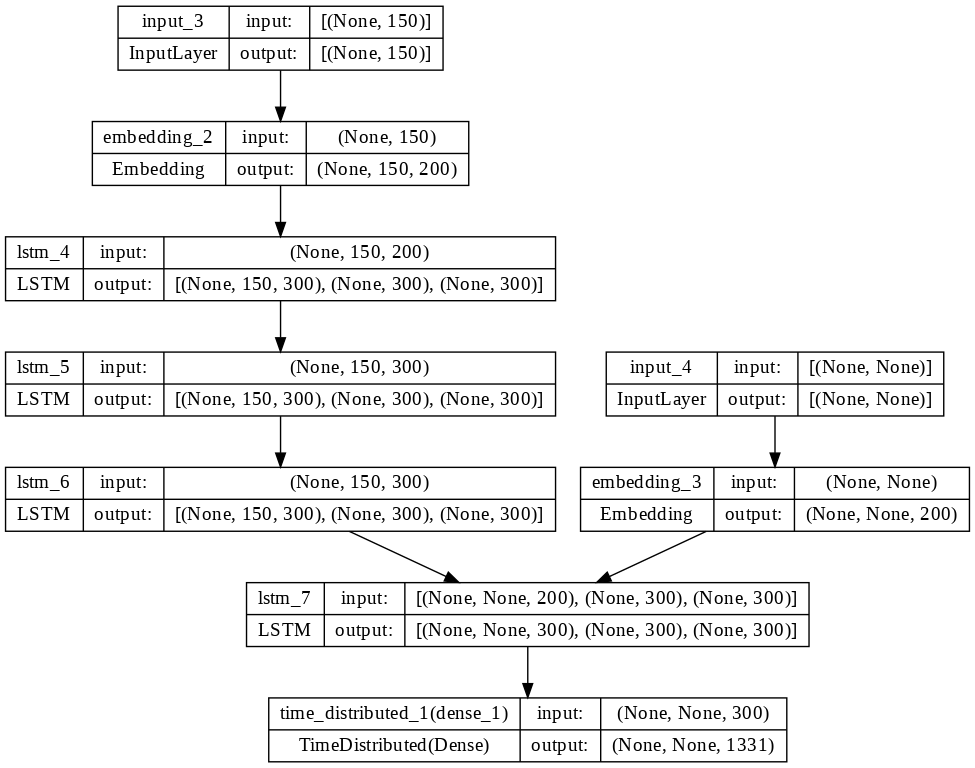

In [ ]:
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from keras.models import Model
from keras.utils.vis_utils import plot_model

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

plot_model(
    model,
    to_file='./encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=100)

In [ ]:
from keras.callbacks import EarlyStopping
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=2)

In [ ]:
history = model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=30,callbacks=[es],
                  batch_size=1024,
                  validation_split=0.1)

Epoch 1/30
16/16 [==============================] - 633s 39s/step - loss: 1.6561 - val_loss: 0.5494
Epoch 2/30
16/16 [==============================] - 618s 38s/step - loss: 0.5482 - val_loss: 0.5340
Epoch 3/30
16/16 [==============================] - 592s 37s/step - loss: 0.5261 - val_loss: 0.4980
Epoch 4/30
16/16 [==============================] - 610s 38s/step - loss: 0.4865 - val_loss: 0.4603
Epoch 5/30
16/16 [==============================] - 598s 37s/step - loss: 0.4624 - val_loss: 0.4504
Epoch 6/30
16/16 [==============================] - 596s 37s/step - loss: 0.4528 - val_loss: 0.4446
Epoch 7/30
16/16 [==============================] - 614s 38s/step - loss: 0.4462 - val_loss: 0.4375
Epoch 8/30
16/16 [==============================] - 604s 37s/step - loss: 0.4400 - val_loss: 0.4325
Epoch 9/30
16/16 [==============================] - 601s 37s/step - loss: 0.4347 - val_loss: 0.4298
Epoch 10/30
16/16 [==============================] - 610s 38s/step - loss: 0.4314 - val_loss: 0.4280

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
decode_sequence(x_tr[101].reshape(1,max_text_len))

1/1 [==============================] - 0s 38ms/step


' great product'

In [ ]:
from transformers import pipeline

summarizer1 = pipeline("summarization", model="facebook/bart-large-cnn")
summarizer2 = pipeline("summarization", model="facebook/bart-large-xsum")

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rougeL','rougeLsum'], use_stemmer=True)

def calc_rouge_scores(candidates, references):
    result = scorer.score(candidates,references)
    result = {key: round(value.fmeasure * 100, 2) for key, value in result.items()}
    return result


In [ ]:
rouge_cnn = pd.DataFrame(columns=['rouge1','rouge2','rougeL','rougeLsum'])
rouge_test = pd.DataFrame(columns=['rouge1','rouge2','rougeL','rougeLsum'])

In [ ]:
for i in range(test.shape[0]):
    # print(i)
    txt = test['Text'].tolist()[i]
    if len(txt.split())<60:
       maxl = len(txt.split())
    elif len(txt.split())>900:
       txt = ' '.join(txt.split()[0:900])
       maxl = 60
    else:
       maxl = 60
    try:
      summ_cnn = summarizer1(txt, max_length=maxl, min_length=1)[0]['summary_text']
      summ_test = decode_sequence(test['Text'][i].reshape(1,max_text_len))
      output_cnn = pd.DataFrame(calc_rouge_scores(summ_cnn,test['Summary'].tolist()[i]), index=[0])
      output_test = pd.DataFrame(calc_rouge_scores(summ_test,test['Summary'].tolist()[i]), index=[0])
      rouge_cnn = pd.concat([rouge_cnn, output_cnn], ignore_index=True)
      rouge_test = pd.concat([rouge_test, output_test], ignore_index=True)
    except:
      continue

Token indices sequence length is longer than the specified maximum sequence length for this model (1097 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
np.mean(np.array(r),axis=0)

array([22.15110515,  8.23171674, 17.06806867, 18.5925    ])

In [ ]:
import pandas as pd
rough1 = pd.read_csv('/content/drive/MyDrive/580project/pretrained_rouge.csv')

In [ ]:
N = rough_cnn.shape[0]
x = ['Rouge1']*N+['Rouge2']*N+['RougeL']*N+['RougeLsum']*N
y1 = rough_cnn.iloc[:,0].tolist()+rough_cnn.iloc[:,1].tolist()+rough_cnn.iloc[:,2].tolist()+rough_cnn.iloc[:,3].tolist()
y2 = rough_test.iloc[:,0].tolist()+rough_test.iloc[:,1].tolist()+rough_test.iloc[:,2].tolist()+rough_test.iloc[:,3].tolist()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Box(
    y=y1,
    x=x,
    name='Pretrain',
    boxmean=True,
    boxpoints='outliers',
    whiskerwidth=0.5,
    marker_color='#00cfcc'
))
fig.add_trace(go.Box(
    y=y2,
    x=x,
    name='Selftrian',
    boxmean=True,
    boxpoints='outliers',
    whiskerwidth=0.5,
    marker_color='#e898ac'
))

fig.update_layout(
    boxmode='group',
    title = 'The Evaluation of Two Models',
    title_x = 0.5,
    width=800,
    height=500,
    titlefont = {'size':26,
                 'color':"darkblue",
                 'family':"Serif"},
    xaxis = dict(
        title = 'Metrics',
        titlefont = {'size':20,
                     'family':"Serif"},
        tickfont={'size':20,
                  'family':"Serif"}
    ),
    yaxis = dict(
        title = 'Value',
        titlefont = {'size':20,
                     'family':"Serif"},
        tickfont={'family':"Serif",
                  'size':20}
    ),
    margin=dict(
        l=30,
        r=30,
        b=50,
        t=50
    ),
    paper_bgcolor="#F3F3F3",
    plot_bgcolor="#F3F3F3",
    legend = {'bgcolor':'lightgray',
              'orientation':"h",
              'bordercolor':"Black",
              'yanchor':"top",
              'font':dict(
                  family="Serif",
                  size=18,
                  color="black"
              ),
              'borderwidth':2
              }
)
fig.show()